In [2]:
%load_ext autoreload
%autoreload 2
from gui import SpikeImportGUI
from importers import SpikeImporter
from recordings import MNGRecording

# present the Spike GUI and let the user make his choices
spike_gui = SpikeImportGUI()

importer = SpikeImporter(filepath = spike_gui.filepath, time_channel = spike_gui.time_channel, signal_channel = spike_gui.signal_channel)
    
recording = MNGRecording.from_importer(importer = importer, stimulus_channels = spike_gui.stimulus_channels, \
                                      ap_channels = spike_gui.ap_channels, force_threshold = spike_gui.force_threshold, \
                                      max_ap_gap_time = spike_gui.max_ap_gap)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
List of eletrical stimuli created.
List of extra eletrical stimuli created.
Finished processing AP channel 1 out of 1
List of APs created.
Done with cropping the intervals


In [3]:
'''
Here, we extract some features from the APs:
- postpulse distance (aka latency)
- normalized signal energy
'''
%autoreload 2
from tqdm import tqdm
from feature_extraction import ResponseLatency, NormalizedSignalEnergy, SpikeCount, AdaptiveSpikeCount

print("Extracting features from every AP")
features = [ResponseLatency(regular_el_stimuli = recording.el_stimuli), \
            NormalizedSignalEnergy(), \
            SpikeCount(actpots = recording.actpots, timeframe = 100, num_intervals = 16), \
            AdaptiveSpikeCount(actpots = recording.actpots, timeframe = 100, num_splits = 8)]

for ap in tqdm(recording.actpots):
    # for each of the features, calculate and store in the ap's dict
    for feature in features:
        ap.features[feature.get_feature_name()] = feature.get_feature_value(ap)

    # also, save a reference to the previous electrical stimulus.
    # we might need that later.
    ap.prev_stimuli["regular"] = MNGRecording.get_prev_el_stimulus(ap, recording.el_stimuli)

 18%|██████████████                                                                  | 40/227 [00:00<00:00, 396.09it/s]

Extracting features from every AP


100%|███████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 485.26it/s]


In [6]:
''' 
This cell performs the clustering according to
- distance to previous stimulus
- normalized signal energy of the APs
'''
%autoreload 2
from fibre_tracking import DBSCANClustering
from ipywidgets import interact_manual, fixed, IntSlider, FloatSlider

dbscan = DBSCANClustering()
x = interact_manual(dbscan.perform_clustering, actpots = fixed(recording.actpots), \
                eps = FloatSlider(min = 0.001, max = 0.05, step = 0.001, value = 0.005, readout_format='.3f'), \
                min_samples = IntSlider(min = 1, max = 50, value = 10, step = 1), \
                save_fibre_prediction = fixed(True), \
                plot_results = fixed(True), \
                manual_name = "Update Plot")

interactive(children=(FloatSlider(value=0.005, description='eps', max=0.05, min=0.001, readout_format='.3f', s…

In [7]:
%autoreload 2
from plotting import FallingLeafPlot
from ipywidgets import interact_manual, fixed, IntSlider, FloatSlider

tmin, tmax = importer.get_time_range()
max_interval_length = max([stim.interval_length for stim in recording.el_stimuli])

flplot = FallingLeafPlot()
interact_manual(flplot.plot, regular_stimuli = fixed(recording.el_stimuli), action_potentials = fixed(recording.actpots), \
                t_start = FloatSlider(min = tmin, max = tmax, value = 0), \
                num_intervals = IntSlider(min = 1, max = len(recording.el_stimuli), step = 1, value = 5), \
                post_stimulus_timeframe = FloatSlider(min = 0, max = max_interval_length, value = 0.1), \
                manual_name = "Update Plot")

interactive(children=(FloatSlider(value=0.0, description='t_start', max=440.0), IntSlider(value=5, description…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
%autoreload 2
from fibre_tracking import ActionPotentialTemplate
from metrics import normalized_cross_correlation
import numpy as np
import matplotlib.pyplot as plt

# get the APs for a certain cluster number
cluster_idcs = [0]
filtered_aps = list(filter(lambda ap: ap.implied_fibre_index in cluster_idcs, recording.actpots))

template_candidate = ActionPotentialTemplate.from_ap_list(aps = filtered_aps)
    
template = template_candidate.signal_template
corr = np.array([normalized_cross_correlation(template, ap.raw_signal) for ap in recording.actpots])

plt.figure()
plt.hist(x = corr, bins = 100)
plt.grid(axis = 'both')
plt.xlabel("Normalized correlation coefficient")
plt.ylabel("Frequency")
plt.title("Histogram of correlation for the fibre candidate template")
plt.show()

In [14]:
sc = SpikeCount(actpots = recording.actpots, timeframe = 1600, num_intervals = 16)

# calculate spike count for every AP
for ap in tqdm(recording.actpots):
    ap.features[sc.get_feature_name()] = sc.get_feature_value(ap)

100%|███████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 440.29it/s]


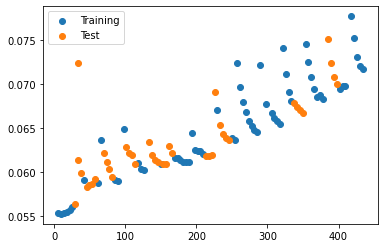

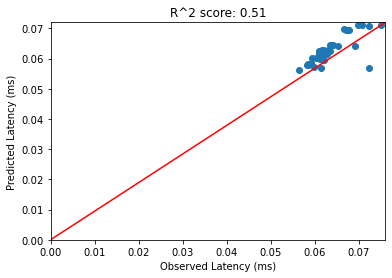

63
40


In [16]:
'''
    Try to perform some linear regression using the spike counts
'''
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from machine_learning import timebased_train_test_split
import matplotlib.pyplot as plt


# restrict to only the "interesting" APs that we suspect as candidates
candidate_aps = [ap for ap in recording.actpots if ap.implied_fibre_index == 0]

# get the features as lists
spike_counts = [ap.features["spike_count"] for ap in candidate_aps]
latencies = [ap.features["latency"] for ap in candidate_aps]

# perform a split on the set to get some data for training and some for evaluation
train_aps, test_aps = timebased_train_test_split(candidate_aps, test_percentage = 0.3, num_test_intervals = 10)

cnts_train = [ap.features["spike_count"] for ap in train_aps]
lat_train = [ap.features["latency"] for ap in train_aps]
cnts_test = [ap.features["spike_count"] for ap in test_aps]
lat_test = [ap.features["latency"] for ap in test_aps]

# plot the segments that have been selected for training and testing
plt.figure()
plt.scatter([ap.onset for ap in train_aps], [ap.features["latency"] for ap in train_aps], label = "Training")
plt.scatter([ap.onset for ap in test_aps], [ap.features["latency"] for ap in test_aps], label = "Test")
plt.legend()
plt.show()

# we should not use this sklearn function because it samples random data points from anywhere in the recording
# cnts_train, cnts_test, lat_train, lat_test = train_test_split(spike_counts, latencies, test_size = 0.2)

regression = LinearRegression().fit(X = cnts_train, y = lat_train)

lat_pred = regression.predict(cnts_test)

plt.figure()
plt.scatter(lat_test, lat_pred)
plt.gca().plot([0, 1], [0, 1], transform = plt.gca().transAxes, color = "r")
plt.xlabel("Observed Latency (ms)")
plt.ylabel("Predicted Latency (ms)")
plt.title("R^2 score: " + "{:.2f}".format(r2_score(lat_test, lat_pred)))
plt.gca().set_ylim(ymin=0)
plt.gca().set_xlim(xmin=0)
plt.show()

print(len(cnts_train))

print(len(cnts_test))

In [ ]:
from feature_extraction import get_spike_count

# restrict to only the "interesting" APs that we suspect as candidates
candidate_aps = [ap for ap in recording.actpots if ap.implied_fibre_index == 0]

timeframe_len = 400

spike_counts = [get_spike_count(actpot = ap, actpots = recording.actpots, timeframe = timeframe_len, num_intervals = 1) for ap in candidate_aps]
latencies = [ap.features["latency"] for ap in candidate_aps]

plt.figure()
plt.scatter(spike_counts, latencies)
plt.xlabel("Number of action potentials in previous " + str(timeframe_len) + "s")
plt.ylabel("Latency of response to stimulus (s)")
plt.gca().set_ylim(ymin=0)
plt.gca().set_xlim(xmin=0)
plt.show()